In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
news_tables = {}

tickers = ['AMZN', 'GOOG', 'TSLA']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url = url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news-table'
    news_table = html.find(id = 'news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [9]:
# Read one single day of headlines for 'AMZN'
amzn = news_tables['AMZN']

# Get all the table rows tagged in HTML with  <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    
    # Read the text of the element 'td' into 'data-text'
    td_text = table_row.td.text
    
    # Print the contents of the 'link_text' and 'data_text'
    print(a_text)
    print(td_text)
    
    # Exit after printing 5 rows of data
    if i == 4:
        break

UPDATE 1-India top court upholds antitrust probe of Amazon, Walmarts Flipkart
Aug-09-21 03:18AM  
India top court upholds antitrust probe of Amazon, Walmarts Flipkart
02:53AM  
India top court says antitrust probe of Amazon, Walmarts Flipkart should continue
02:48AM  
India top court says antitrust probe of Amazon, Walmarts Flipkart should continue
02:37AM  
Seeing link between wages and workers, more businesses raise the former to address the latter
Aug-08-21 08:10PM  


In [4]:
parsed_news = []

#Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text()
        # split text in the td tag into a list
        date_scrape = x.td.text.split()
        # if the lenght of data_scrape is 1, load time as the only element
        
        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'    
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN',
  'Aug-09-21',
  '03:18AM',
  'UPDATE 1-India top court upholds antitrust probe of Amazon, Walmarts Flipkart'],
 ['AMZN',
  'Aug-09-21',
  '02:53AM',
  'India top court upholds antitrust probe of Amazon, Walmarts Flipkart'],
 ['AMZN',
  'Aug-09-21',
  '02:48AM',
  'India top court says antitrust probe of Amazon, Walmarts Flipkart should continue'],
 ['AMZN',
  'Aug-09-21',
  '02:37AM',
  'India top court says antitrust probe of Amazon, Walmarts Flipkart should continue'],
 ['AMZN',
  'Aug-08-21',
  '08:10PM',
  'Seeing link between wages and workers, more businesses raise the former to address the latter'],
 ['AMZN', 'Aug-08-21', '10:50AM', 'Amazon Stock: Investors Expect Too Much'],
 ['AMZN',
  'Aug-08-21',
  '07:30AM',
  'Got $2,000? 3 Explosive Growth Stocks to Buy in August'],
 ['AMZN',
  'Aug-08-21',
  '07:15AM',
  'Amazon Investors Are Getting Its E-Commerce Business for Free'],
 ['AMZN',
  'Aug-07-21',
  '01:07PM',
  'Amazon Offers $500,000 Cash, Cars, And Vacations To

In [6]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set Column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed news list into dataframe
parsed_and_scored_news = pd.DataFrame(parsed_news, columns = columns)

# Get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the scores to dataframe
scores_df = pd.DataFrame(scores)

# Combine both the dataframe together
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix = '_right')

# Convert the date col from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2021-08-09,03:18AM,UPDATE 1-India top court upholds antitrust pro...,0.0,0.720,0.280,0.3612
1,AMZN,2021-08-09,02:53AM,India top court upholds antitrust probe of Ama...,0.0,0.696,0.304,0.3612
2,AMZN,2021-08-09,02:48AM,India top court says antitrust probe of Amazon...,0.0,0.741,0.259,0.3612
3,AMZN,2021-08-09,02:37AM,India top court says antitrust probe of Amazon...,0.0,0.741,0.259,0.3612
4,AMZN,2021-08-08,08:10PM,"Seeing link between wages and workers, more bu...",0.0,1.000,0.000,0.0000


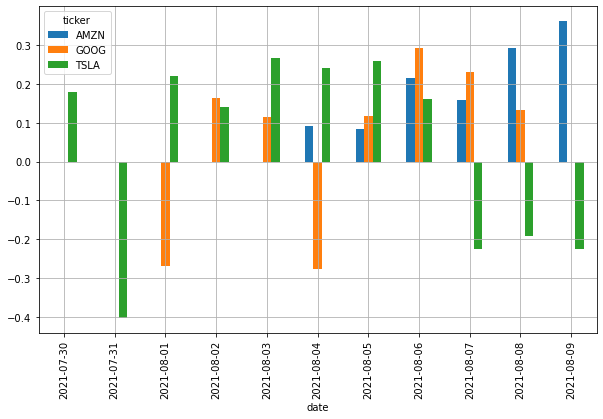

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group the date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'column' axis
mean_scores = mean_scores.xs('compound', axis = 'columns').transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()